## This Notebook is created to demonstrate capability of Pyspark with Kaggle California Housing dataset. 

                                                                    --By Partha Chowdhury 
                                                        If it helps, please give upvote.

Pyspark is faster than others as it does in-memory calculations. It has many other aspects and its highlighted below. 

In this we'll make use of the California Housing data set. Note, of course, that this is actually 'small' data and that using Spark in this context might be overkill; This notebook is for educational purposes only and is meant to give us an idea of how we can use PySpark to build a machine learning model.

![](https://miro.medium.com/max/1068/1*0DduCSleektW3HiuMeYRGQ.png)

<a id="TOC"></a> <br>
**Table of Contents:**  
[1. Understanding the Dataset](#1)  
[2. Creating the Spark Session](#2)<br> 
[3. Load The Data From a File Into a Dataframe](#3) <br> 
[4. Data Exploration](#4) <br>
    [4.1 Distribution of the median age of the people living in the area](#4p1)  <br>
    [4.2 Summary Statistics](#4p2) <br>
[5. Data Preprocessing](#5) <br>
    [5.1 Preprocessing The Target Values](#5p1)  <br>
[6. Feature Engineering](#6) <br>
    [6.1 Feature Extraction](#6p1)  <br>
    [6.2 Standardization](#6p2) <br>
[7. Building A Machine Learning Model With Spark ML](#7) <br>
    [7.1 Bias and Variance Explanation](#7p1)  <br>
    [7.2 Ridge Regression Theory](#7p2)<br> 
    [7.3 Create an ElasticNet model](#7p3) <br>
[8. Evaluating the Model](#8) <br>
    [8.1 Inspect the Model Co-efficients](#8p1) <br> 
    [8.2 Generating Predictions](#8p2) <br>
    [8.3 Inspect the Metrics](#8p3) 

<a id="1"></a> <br>
# 1. Understanding the Data Set

The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). In this sample a block group on average includes 1425.5 individuals living in a geographically compact area.

These spatial data contain 20,640 observations on housing prices with 9 economic variables:

**Longitude**:refers to the angular distance of a geographic place north or south of the earth’s equator for each block group <br>
**Latitude** :refers to the angular distance of a geographic place east or west of the earth’s equator for each block group <br>
**Housing Median Age**:is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values <br>
**Total Rooms**:is the total number of rooms in the houses per block group <br>
**Total Bedrooms**:is the total number of bedrooms in the houses per block group <br>
**Population**:is the number of inhabitants of a block group <br>
**Households**:refers to units of houses and their occupants per block group <br>
**Median Income**:is used to register the median income of people that belong to a block group <br>
**Median House Value**:is the dependent variable and refers to the median house value per block group <br>

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hausing-data/cal_housing.data


In [6]:
!pip install pyspark

Import necessary libfraries

In [7]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [10]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

<a id="2"></a> <br>
# 2. Creating the Spark Session

In [11]:
spark=SparkSession.builder.master("local[2]").appName("Linear-Regression-California-Housing").getOrCreate()  

In [12]:
spark

SparkContext. Main entry point for Spark functionality. A SparkContext represents the connection to a Spark cluster, and can be used to create RDD and broadcast variables on that cluster.

In [13]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Linear-Regression-California-Housing>

In [14]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

[Table of Contents](#TOC) Click here to go back to 'Table of Contents'

<a id="3"></a> <br>
# 3. Load The Data From a File Into a Dataframe

In [15]:
HOUSING_DATA = '../input/hausing-data/cal_housing.data'

Specifying the schema when loading data into a DataFrame will give better performance than schema inference.

In [16]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

In [17]:
# Load housing data
housing_df = spark.read.csv(path=HOUSING_DATA, schema=schema).cache()

In [18]:
housing_df.take(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

In [19]:
housing_df.head()

Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0)

In [20]:
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows



In [21]:
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [22]:
housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



[Table of Contents](#TOC) Click here to go back to 'Table of Contents'

<a id="4"></a> <br>
# 4. Data Exploration

In [23]:
#run sample selection
housing_df.select('pop','totrooms').show(10)

+------+--------+
|   pop|totrooms|
+------+--------+
| 322.0|   880.0|
|2401.0|  7099.0|
| 496.0|  1467.0|
| 558.0|  1274.0|
| 565.0|  1627.0|
| 413.0|   919.0|
|1094.0|  2535.0|
|1157.0|  3104.0|
|1206.0|  2555.0|
|1551.0|  3549.0|
+------+--------+
only showing top 10 rows



<a id="4p1"></a> <br>
### 4.1 Distribution of the median age of the people living in the area:

In [24]:
# group by housingmedianage and see the distribution
result_df=housing_df.groupBy("medage").count().sort("medage",ascending=False)
result_df.show()

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
|  42.0|  368|
|  41.0|  296|
|  40.0|  304|
|  39.0|  369|
|  38.0|  394|
|  37.0|  537|
|  36.0|  862|
|  35.0|  824|
|  34.0|  689|
|  33.0|  615|
+------+-----+
only showing top 20 rows



DataFrame.toPandas()  
Returns the contents of this DataFrame as Pandas pandas.DataFrame.

<AxesSubplot:xlabel='medage'>

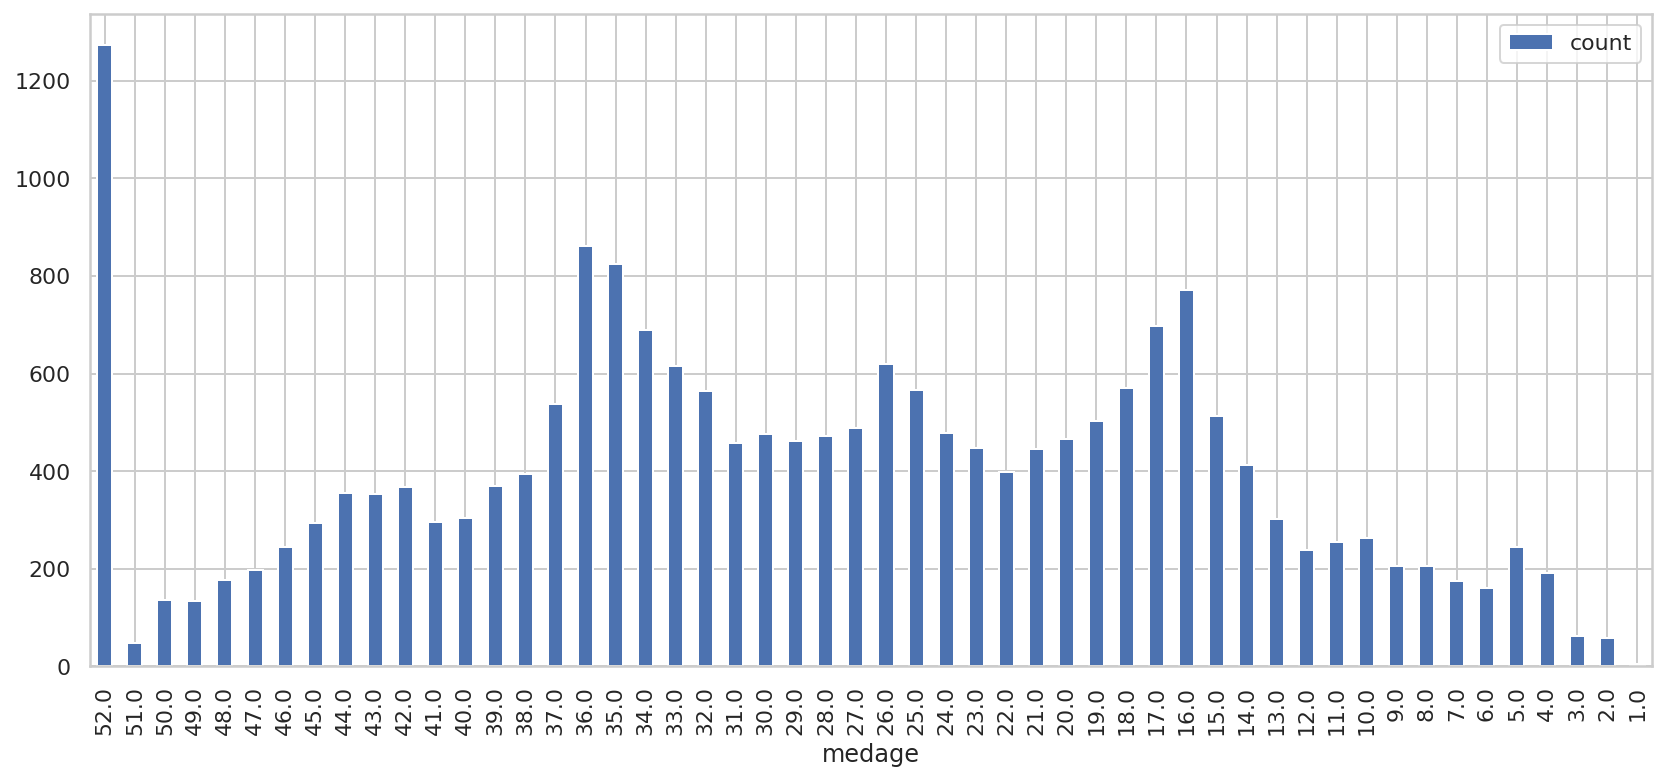

In [25]:
result_df.toPandas().plot.bar(x='medage', y='count',figsize=(14,6))

<a id="4p2"></a> <br>
### 4.2 Summary Statistics:  
Spark DataFrames include some built-in functions for statistical processing. The describe() function performs summary statistics calculations on all numeric columns and returns them as a DataFrame.

In [26]:
housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv")).show()

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



We see that multiple attributes have a wide range of values: we will need to normalize your dataset.

[Table of Contents](#TOC) Click here to go back to 'Table of Contents'

<a id="5"></a> <br>
## 5. Data Preprocessing  
With all this information that we gathered from our small exploratory data analysis, we know enough to preprocess our data to feed it to the model.  

we shouldn't care about missing values; all zero values have been excluded from the data set.  
We should probably standardize our data, as we have seen that the range of minimum and maximum values is quite big.  
There are possibly some additional attributes that we could add, such as a feature that registers the number of bedrooms per room or the rooms per household.  
Our dependent variable is also quite big; To make our life easier, we'll have to adjust the values slightly.

<a id="5p1"></a> <br>
### 5.1 Preprocessing The Target Values
First, let's start with the medianHouseValue, our dependent variable. To facilitate our working with the target values, we will express the house values in units of 100,000. That means that a target such as 452600.000000 should become 4.526:

DataFrame.withColumn(colName, col)
Returns a new DataFrame by adding a column or replacing the existing column that has the same name.

In [27]:
# Adjust the values of `medianHouseValue'
housing_df=housing_df.withColumn("medhv",col('medhv')/100000)
housing_df.show(3)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 3 rows



<a id="6"></a> <br>
## 6. Feature Engineering  
Now that we have adjusted the values in medianHouseValue, we will now add the following columns to the data set:  

Rooms per household which refers to the number of rooms in households per block group;  
Population per household, which basically gives us an indication of how many people live in households per block group; And  
Bedrooms per room which will give us an idea about how many rooms are bedrooms per block group;    

As we're working with DataFrames, we can best use the select() method to select the columns that we're going to be working with, namely totalRooms, households, and population.   Additionally, we have to indicate that we're working with columns by adding the col() function to our code. Otherwise, we won't be able to do element-wise operations like the division that we have in mind for these three variables:

In [28]:
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [29]:
%config Completer.use_jedi = False

In [30]:
# Add the new columns to `df`
housing_df=(housing_df.withColumn('rmsperhh',F.round(col('totrooms')/col('houshlds'),2))
            .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

In [31]:
# Inspect the result
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



We can see that, for the first row, there are about 6.98 rooms per household, the households in the block group consist of about 2.5 people and the amount of bedrooms is quite low with 0.14:  


Since we don't want to necessarily standardize our target values, we'll want to make sure to isolate those in our data set. Note also that this is the time to leave out variables that we might not want to consider in our analysis. In this case, let's leave out variables such as longitude, latitude, housingMedianAge and totalRooms.  

In this case, we will use the select() method and passing the column names in the order that is more appropriate. In this case, the target variable medianHouseValue is put first, so that it won't be affected by the standardization.

In [32]:
housing_df=housing_df.select("medhv","totbdrms", 
                              "pop", 
                              "houshlds", 
                              "medinc", 
                              "rmsperhh", 
                              "popperhh", 
                              "bdrmsperrm")
housing_df.show(5)

+-----+--------+------+--------+------+--------+--------+----------+
|medhv|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|
+-----+--------+------+--------+------+--------+--------+----------+
|4.526|   129.0| 322.0|   126.0|8.3252|    6.98|    2.56|      0.15|
|3.585|  1106.0|2401.0|  1138.0|8.3014|    6.24|    2.11|      0.16|
|3.521|   190.0| 496.0|   177.0|7.2574|    8.29|     2.8|      0.13|
|3.413|   235.0| 558.0|   219.0|5.6431|    5.82|    2.55|      0.18|
|3.422|   280.0| 565.0|   259.0|3.8462|    6.28|    2.18|      0.17|
+-----+--------+------+--------+------+--------+--------+----------+
only showing top 5 rows



[Table of Contents](#TOC) Click here to go back to 'Table of Contents'

<a id="6p1"></a> <br>
### 6.1 Feature Extraction  
Now that we have re-ordered the data, we're ready to normalize the data. We will choose the features to be normalized.

In [33]:
featureCols=["totbdrms", "pop","houshlds","medinc","rmsperhh","popperhh","bdrmsperrm"]

Use a VectorAssembler to put features into a feature vector column. THis is the way MLlib works in Pyspark

In [34]:
assembler=VectorAssembler(inputCols=featureCols, outputCol="features")

In [35]:
assembled_df=assembler.transform(housing_df)
assembled_df.show(5, truncate= False )

+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                               |
+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28    |2.18    |0.17      |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17]  |


All the features have transformed into a Dense Vector.

<a id="6p2"></a> <br>
### 6.2 Standardization  
Next, we can finally scale the data using StandardScaler. The input columns are the features, and the output column with the rescaled that will be included in the scaled_df will be named "features_scaled":**

In [36]:
# Initialize the `standardScaler`
standardScaler=StandardScaler(inputCol="features",outputCol='features_scaled')

In [37]:
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [38]:
# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

<a id="7"></a> <br>
## 7. Building A Machine Learning Model With Spark ML

With all the preprocessing done, it's finally time to start building our Linear Regression model! Just like always, we first need to split the data into training and test sets. Luckily, this is no issue with the randomSplit() method:

In [39]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=rnd_seed)

In [40]:
train_data.columns

['medhv',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_scaled']

Research:   
Regularization: Ridge, Lasso and Elastic Net  
Link: https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net

[Table of Contents](#TOC) Click here to go back to 'Table of Contents'

<a id="7p1"></a> <br>
### 7.1 Bias and Variance Explanation 

This graphic illustrates what bias and variance are. Imagine the bull's-eye is the true population parameter that we are estimating, β, and the shots at it are the values of our estimates resulting from four different estimators - low bias and variance, high bias and variance, and the combinations thereof.  
![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1543418451/bias_vs_variance_swxhxx.jpg)

The OLS estimator has the desired property of being unbiased. However, it can have a huge variance. Specifically, this happens when:  

The predictor variables are highly correlated with each other;  
There are many predictors. This is reflected in the formula for variance given above: if m approaches n, the variance approaches infinity.  
The general solution to this is: reduce variance at the cost of introducing some bias. This approach is called regularization and is almost always beneficial for the predictive performance of the model. To make it sink in, let's take a look at the following plot.

<a id="7p2"></a> <br>
### 7.2 Ridge Regression Theory 
From the discussion so far we have concluded that we would like to decrease the model complexity, that is the number of predictors. We could use the forward or backward selection for this, but that way we would not be able to tell anything about the removed variables' effect on the response. Removing predictors from the model can be seen as settings their coefficients to zero. Instead of forcing them to be exactly zero, let's penalize them if they are too far from zero, thus enforcing them to be small in a continuous way. This way, we decrease model complexity while keeping all variables in the model. This, basically, is what Ridge Regression does.

Note that the argument elasticNetParam corresponds to  α  or the vertical intercept and that the regParam or the regularization paramater corresponds to  λ .

<a id="7p3"></a> <br>
## 7.3 Create an ElasticNet model:

ElasticNet is a linear regression model trained with L1 and L2 prior as regularizer. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. We control the convex combination of L1 and L2 using the l1_ratio parameter.

Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

A practical advantage of trading-off between Lasso and Ridge is it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

In [41]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='features_scaled', labelCol="medhv", predictionCol='predmedhv', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [42]:
# Fit the data to the model
linearModel = lr.fit(train_data)

[Table of Contents](#TOC) Click here to go back to 'Table of Contents'

<a id="8"></a> <br>
## 8. Evaluating the Model  
With our model in place, we can generate predictions for our test data: use the transform() method to predict the labels for our test_data. Then, we can use RDD operations to extract the predictions as well as the true labels from the DataFrame.

<a id="8p1"></a> <br>
### 8.1 Inspect the Model Co-efficients

In [43]:
# Coefficients for the model
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.5262, 0.0, 0.0, 0.0])

In [44]:
featureCols

['totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']

In [45]:
# Intercept for the model
linearModel.intercept

1.0013833516596085

In [46]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]

In [47]:
coeff_df

,Feature,Co-efficients
0,Intercept,1.001383
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.526157
5,rmsperhh,0.000000
6,popperhh,0.000000
7,bdrmsperrm,0.000000


<a id="8p2"></a> <br>
### 8.2 Generating Predictions

In [48]:
# Generate predictions
predictions = linearModel.transform(test_data)
# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("predmedhv", "medhv")

In [49]:
predandlabels.show()

+------------------+-------+
|         predmedhv|  medhv|
+------------------+-------+
|  1.14982901467337|0.14999|
|1.3037582901805782|  0.225|
| 1.752972574315186|  0.225|
|1.6094289295308724|  0.269|
|1.5956645319495768|  0.344|
|1.2917940087238426|  0.367|
|1.8668547795751218|  0.375|
| 1.369423339785637|  0.394|
|1.5305533439120043|  0.398|
|1.5715143715849273|  0.409|
|1.3261913014043998|  0.417|
| 1.229923204690587|  0.425|
|1.4841640700933143|  0.425|
|1.3510338217435218|   0.43|
|1.2619110212709588|  0.436|
|1.3350814464678744|   0.44|
|1.4832778453641755|   0.44|
|1.4337313361080328|  0.444|
|1.3691187093204966|  0.445|
|  1.47521855868216|  0.446|
+------------------+-------+
only showing top 20 rows



<a id="8p3"></a> <br>
### 8.3 Inspect the Metrics  
Looking at predicted values is one thing, but another and better thing is looking at some metrics to get a better idea of how good your model actually is.  

Using the LinearRegressionModel.summary attribute:  

Next, we can also use the summary attribute to pull up the rootMeanSquaredError and the r2.

In [50]:
# Get the RMSE
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))

RMSE: 0.8819852045268861


In [51]:
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

MAE: 0.6782895319917991


In [52]:
# Get the R2
print("R2: {0}".format(linearModel.summary.r2))

R2: 0.4180854895364573


* The RMSE measures how much error there is between two datasets comparing a predicted value and an observed or known value. The smaller an RMSE value, the closer predicted and observed values are.  
   
* The R2 ("R squared") or the coefficient of determination is a measure that shows how close the data are to the fitted regression line. This score will always be between 0 and a 100% (or 0 to 1 in this case), where 0% indicates that the model explains none of the variability of the response data around its mean, and 100% indicates the opposite: it explains all the variability. That means that, in general, the higher the R-squared, the better the model fits our data.  

Using the RegressionEvaluator from pyspark.ml package:

In [53]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predandlabels)))

RMSE: 0.8677342923034236


In [54]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predandlabels)))

MAE: 0.6736097745764633


In [55]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predandlabels)))

R2: 0.42517112885139363


### Using the RegressionMetrics from pyspark.mllib package:

In [56]:
# mllib is old so the methods are available in rdd
metrics = RegressionMetrics(predandlabels.rdd)
print("RMSE: {0}".format(metrics.rootMeanSquaredError))

RMSE: 0.8677342923034236


In [57]:
print("MAE: {0}".format(metrics.meanAbsoluteError))

MAE: 0.6736097745764633


In [58]:
print("R2: {0}".format(metrics.r2))

R2: 0.42517112885139363


There's definitely some improvements needed to our model! If we want to continue with this model, we can play around with the parameters that we passed to your model, the variables that we included in your original DataFrame.   
It gives us a good idea about how Pyspark works. 

In [59]:
spark.stop()

> *Partha Chowdhury signing off*

[Table of Contents](#TOC) Click here to go back to 'Table of Contents'